# NE with 20 files and with lag 7

In [1]:
# STEP 1: Install Tigramite with J-PCMCI+
!pip install tigramite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.6/309.6 kB 4.6 MB/s eta 0:00:00


In [2]:
# STEP 2: Import libraries
import os, glob, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tigramite.jpcmciplus import JPCMCIplus
from tigramite.data_processing import DataFrame
from tigramite.independence_tests.regressionCI import RegressionCI
from tigramite.plotting import plot_time_series_graph, plot_graph

In [3]:
# STEP 3: Unzip and randomly select 20 CW CSV files
!unzip -q lakes_by_region.zip -d lakes_by_region

no_dir = "/content/lakes_by_region/NE"
all_csv_files = glob.glob(os.path.join(no_dir, "*.csv"))
random.seed(42)  # For reproducibility
csv_files = random.sample(all_csv_files, 20)
print(f"Randomly selected {len(csv_files)} NE datasets.")

Randomly selected 20 NE datasets.


In [4]:
# STEP 4: Prepare data_dict with dummies
system_vars = [
    "HV.anom", "S2.water", "S2.zenith", "LS.water", "LS.zenith",
    "r2", "sp", "sst", "t2m"
]
T = 365
raw_data_dict = {}
for domain_idx, file in enumerate(csv_files):
    df = pd.read_csv(file)
    df.columns = [col.replace("_", ".") for col in df.columns]  # convert to dot notation
    if df[system_vars].shape[0] != T or df[system_vars].isnull().values.any():
        continue
    time_dummy = np.linspace(0, T-1, T).reshape(-1, 1)
    space_dummy = np.full((T, 1), domain_idx)
    combined = np.hstack([df[system_vars].values, time_dummy, space_dummy])
    raw_data_dict[domain_idx] = combined

# Remap keys to 0...N
data_dict = {i: v for i, (_, v) in enumerate(raw_data_dict.items())}

In [5]:
# STEP 5: Build DataFrame and metadata
N_sys = len(system_vars)
time_dummy_index = N_sys
space_dummy_index = N_sys + 1
var_names = [f"${v}$" for v in system_vars] + ["t-dummy", "s-dummy"]
nb_domains = len(data_dict)

data_type = np.zeros((nb_domains, T, len(var_names)), dtype=int)
data_type[:, :, time_dummy_index] = 1
data_type[:, :, space_dummy_index] = 1

dataframe = DataFrame(
    data=data_dict,
    analysis_mode='multiple',
    var_names=var_names,
    data_type=data_type
)

node_classification = {
    **{i: "system" for i in range(N_sys)},
    time_dummy_index: "time_dummy",
    space_dummy_index: "space_dummy"
}


In [6]:
# STEP 6: Run J-PCMCI+ with RegressionCI
jpcmci = JPCMCIplus(
    dataframe=dataframe,
    cond_ind_test=RegressionCI(significance='analytic'),
    node_classification=node_classification,
    verbosity=1
)

results = jpcmci.run_jpcmciplus(
    tau_min=0,
    tau_max=7,
    pc_alpha=0.01
)



##
## J-PCMCI+ Step 1: Selecting lagged conditioning sets
##

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
link_assumptions = {0: {(0, -1): '-?>', (0, -2): '-?>', (0, -3): '-?>', (0, -4): '-?>', (0, -5): '-?>', (0, -6): '-?>', (0, -7): '-?>', (1, 0): 'o?o', (1, -1): '-?>', (1, -2): '-?>', (1, -3): '-?>', (1, -4): '-?>', (1, -5): '-?>', (1, -6): '-?>', (1, -7): '-?>', (2, 0): 'o?o', (2, -1): '-?>', (2, -2): '-?>', (2, -3): '-?>', (2, -4): '-?>', (2, -5): '-?>', (2, -6): '-?>', (2, -7): '-?>', (3, 0): 'o?o', (3, -1): '-?>', (3, -2): '-?>', (3, -3): '-?>', (3, -4): '-?>', (3, -5): '-?>', (3, -6): '-?>', (3, -7): '-?>', (4, 0): 'o?o', (4, -1): '-?>', (4, -2): '-?>', (4, -3): '-?>', (4, -4): '-?>', (4, -5): '-?>', (4, -6): '-?>', (4, -7): '-?>', (5, 0): 'o?o', (5, -1): '-?>', (5, -2): '-?>', (5, -3): '-?>', (5, -4): '-?>', (5, -5): '-?>', (5, -6): '-?>', (5, -7): '-?>', (6, 0): 'o?o', (6, -1): '-?>', (6, -2): '-?>', (6, -3): '-?>', (6, -4): '-?>', (6, -5): '-

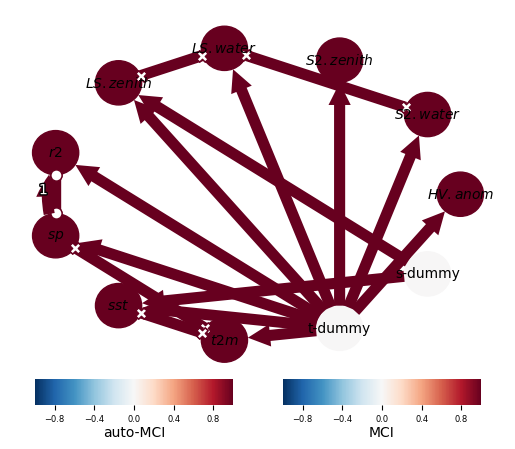

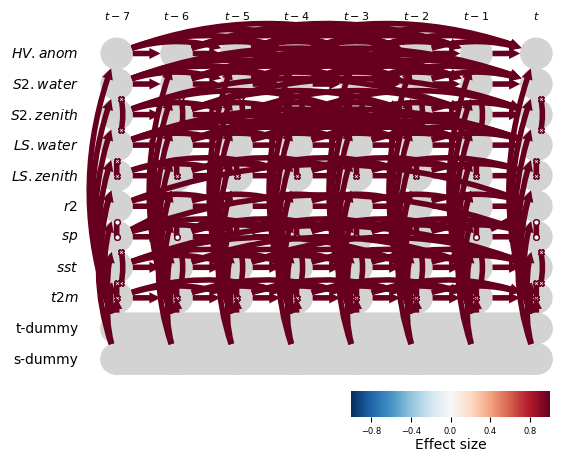

In [7]:
import tigramite.plotting as tp
import matplotlib.pyplot as plt

# Simple adjacency graph
tp.plot_graph(
    results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names
)

# Time-lagged causal graph with dummy/system coloring
tp.plot_time_series_graph(
    graph=results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    node_classification=node_classification,
    link_colorbar_label="Effect size"
)

plt.show()
